In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv, matplotlib.pyplot as plt, pandas as pd
import torch.nn as nn, timeit, torch, pystan as ps
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="/home/postdoc/dsen/Desktop/VAE_density/stan_files/nn_refpoints_constrainedtheta.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf61588642e0539b092dedc55e934141 NOW.


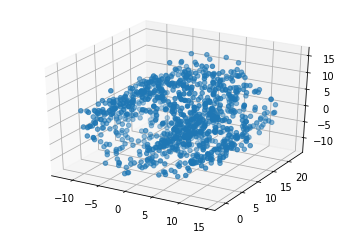

In [4]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=1e0, random_state=None)
X = X.transpose()
Nobs = np.shape(X)[1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[0], X[1], X[2])

### Local linear embedding for reference points:

In [5]:
n_ref = 20
lat_dim = 2
obs_dim = np.shape(X)[0] 
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=lat_dim,n_neighbors=20)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [7]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [8]:
n_in = np.shape(X_embedded)[0]
n_h = 15
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h), nn.Tanh(), nn.Linear(n_h, n_out))

In [9]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [10]:
n_iter = 1_000_000
Lss = np.zeros(n_iter)
start = time()
for epoch in range(n_iter):
    X_pred = model(torch.from_numpy(Z_ref.transpose().astype(np.float32)))
    loss = criterion(X_pred, torch.from_numpy(X_ref.transpose().astype(np.float32)))
    Lss[epoch] = loss.data
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 100000; loss: 11.034; time: 0.4 mins
Epoch: 200000; loss: 7.381; time: 0.8 mins
Epoch: 300000; loss: 5.352; time: 1.2 mins
Epoch: 400000; loss: 3.384; time: 1.5 mins
Epoch: 500000; loss: 2.738; time: 1.9 mins
Epoch: 600000; loss: 2.035; time: 2.3 mins
Epoch: 700000; loss: 1.337; time: 2.7 mins
Epoch: 800000; loss: 0.927; time: 3.0 mins
Epoch: 900000; loss: 0.659; time: 3.4 mins
Epoch: 1000000; loss: 0.438; time: 3.8 mins


In [11]:
for (i,p) in enumerate(model.parameters()):
    if i == 0 : W_1_optim = p.data;
    print(np.shape(p))

torch.Size([15, 2])
torch.Size([15])
torch.Size([3, 15])
torch.Size([3])


In [13]:
c = [np.linalg.norm(W_1_optim[i,:]) for i in range(n_in)]
for i in range(n_ref) : Z_ref[:,i] *= c

In [14]:
data = dict(Nobs=Nobs, in_dim=n_in, out_dim=n_out, hidden_dim=n_h, n_ref=n_ref, X=X_train, X_ref=X_ref, Z_ref=Z_ref)

### Run Stan:

In [15]:
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, init="random", iter=1000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


12.44 minutes to run
Inference for Stan model: anon_model_cf61588642e0539b092dedc55e934141.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]              -0.15    0.01   0.99  -2.08  -0.82  -0.14    0.5   1.81   6256    1.0
Z[2,1]               0.07    0.01   0.95   -1.8  -0.56   0.08   0.71   1.93   5585    1.0
Z[3,1]               0.05    0.01    1.0  -1.91  -0.64   0.04   0.73   2.01   9479    1.0
Z[4,1]               0.08    0.01   0.97   -1.9  -0.54    0.1   0.72   1.94   6278    1.0
Z[5,1]                0.1  9.7e-3   1.03  -1.88  -0.62   0.11   0.84   2.07  11356    1.0
Z[6,1]               0.09    0.02   0.98  -1.81  -0.58   0.09   0.75   2.03   3474    1.0
Z[7,1]               0.03  9.9e-3   1.01  -1.93  -0.66   0.04   0.73   1.99  10340    1.0
Z[8,1]              -0.25    0.01   0.94  -2.07   -0.9  -0.25   0.39   

In [16]:
trace = fit.extract()
n_samples, n_latent = np.shape(trace['Z'])[0], np.shape(trace['Z'])[1]

### Traceplots of latent variables:

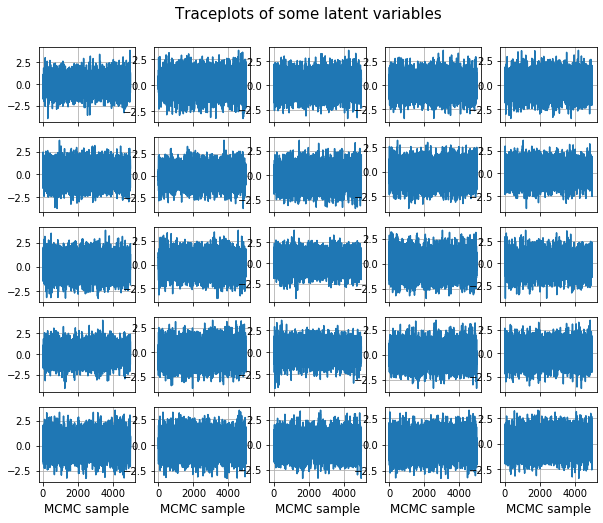

In [17]:
plt.figure(figsize=(10,8))
idx = npr.choice(n_latent,25).reshape(5,5)

for i in range(5):
    for j in range(5):
        k = 5*i+j
        plt.subplot(5,5,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 4 : plt.xticks(alpha=0)
        if i == 4 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=15, x=0.5,y=0.95)
plt.show()

### Loss:

100%|██████████| 5000/5000 [00:01<00:00, 3001.51it/s]


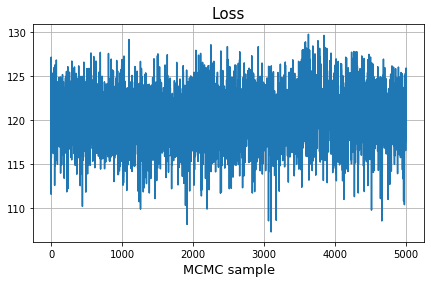

In [19]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), trace['Z'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)

### Pairwise distances:

In [ ]:
k_max = 50

pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for k in trange(n_samples) :
    for i in range(k_max) :
        for j in range(k_max) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

In [ ]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 5 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
            if j == 0 : plt.ylabel("Distance", fontsize=12)
plt.suptitle("Traceplots of some pairwise distances of latent variables for hypersphere", fontsize=14, x=0.31,y=0.83)
plt.savefig('/home/postdoc/dsen/Desktop/VAE_density/plots/swissroll_pwdist_unconstrainedW1_refpoints.pdf', 
                dpi=2000, bbox_inches='tight');